In [1]:
import pandas as pd
import os
import opendatasets as od
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2 as cv
import random as rnd
from functions import *

In [2]:
get_class_directories()

['jellyfish-types/compass_jellyfish/',
 'jellyfish-types/Moon_jellyfish/',
 'jellyfish-types/blue_jellyfish/',
 'jellyfish-types/lions_mane_jellyfish/',
 'jellyfish-types/barrel_jellyfish/']

In [3]:
len(get_jpgs())

737

### Generating Dataset

Rewriting the code to get the list of images. The project calls for no more than 100 of each class of the target variable and no more than 5 classes of the target variable.

In [4]:
def get_imgs():
    imgs = []
    for cd in get_class_directories():
        for i in range(100):
            imgs.append(cd + os.listdir(cd)[i])
    return imgs

In [5]:
len(get_imgs())

500

The function to get the list of y values corresponding with each image in x also needed to be rewritten so that it lined up the way it was supposed to.

In [6]:
def get_target():
    target = []
    imgs = get_imgs()
    for i in range(len(imgs)):
        if 'compass' in imgs[i]:
            target.append('compass')
        elif 'Moon' in imgs[i]:
            target.append('Moon')
        elif 'blue' in imgs[i]:
            target.append('blue')
        elif 'lions_mane' in imgs[i]:
            target.append('lions_mane')
        elif 'barrel' in imgs[i]:
            target.append('barrel')
    return target

In [7]:
def get_x_data():
    imgs = get_imgs()
    x = []
    for i in range(len(imgs)):
        img_data = resize(cv.imread(imgs[i]), (224, 224))
        x.append(img_data)
    return np.asarray(x)

In [8]:
x = get_x_data()

In [9]:
y = get_target()

One hot encoding the target variable so that the shape lines up with the number of neurons that are supposed to be in the output layer of a multiclass classification neural network.

In [10]:
y = pd.get_dummies(pd.DataFrame(y))

In [11]:
y = y.replace({True: 1, False: 0})

In [12]:
y = np.asarray(y)

##### Train Test Split

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

In [15]:
len(x_train), len(x_test)

(350, 150)

In [16]:
len(y_train), len(y_test)

(350, 150)

### First Pre-Built Keras Model: ResNet50

The first model will be a simple one with ResNet50 as its foundation. After getting results with this model, data augmentation will be done and then it will be done again.

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, Rescaling
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import resnet

2024-04-29 13:04:43.201059: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 13:04:43.502653: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-29 13:04:43.542912: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/clay/.local/lib/python3.8/site-packages/cv2/../../lib64:
2024-04-29 13:04:43.

In [18]:
def ResNetModel1(input_shape):
    base = ResNet50(input_shape = input_shape, weights = 'imagenet',
                    include_top = False, pooling = 'avg')
    base.trainable = False
    
    inputs = Input(input_shape)
    x = resnet.preprocess_input(inputs)
    x = base(x)
    outputs = Dense(5, activation = 'softmax')(x)
    
    return Model(inputs, outputs, name = 'ResNetModel1')

In [19]:
model1 = ResNetModel1(input_shape = (224, 224, 3))

2024-04-29 13:04:46.680263: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/clay/.local/lib/python3.8/site-packages/cv2/../../lib64:
2024-04-29 13:04:46.680344: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-29 13:04:46.680362: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-AB0NGOS5): /proc/driver/nvidia/version does not exist
2024-04-29 13:04:46.681713: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with

In [20]:
model1.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [21]:
history = model1.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 10)

Epoch 1/10
11/11 [==============================] - 22s 2s/step - loss: 1.4776 - accuracy: 0.4314 - val_loss: 0.8019 - val_accuracy: 0.7400
Epoch 2/10
11/11 [==============================] - 20s 2s/step - loss: 0.5764 - accuracy: 0.8143 - val_loss: 0.5828 - val_accuracy: 0.7933
Epoch 3/10
11/11 [==============================] - 20s 2s/step - loss: 0.3336 - accuracy: 0.8914 - val_loss: 0.4115 - val_accuracy: 0.8267
Epoch 4/10
11/11 [==============================] - 20s 2s/step - loss: 0.2269 - accuracy: 0.9457 - val_loss: 0.3739 - val_accuracy: 0.8667
Epoch 5/10
11/11 [==============================] - 20s 2s/step - loss: 0.1717 - accuracy: 0.9571 - val_loss: 0.3329 - val_accuracy: 0.8800
Epoch 6/10
11/11 [==============================] - 20s 2s/step - loss: 0.1334 - accuracy: 0.9800 - val_loss: 0.3168 - val_accuracy: 0.8733
Epoch 7/10
11/11 [==============================] - 20s 2s/step - loss: 0.1060 - accuracy: 0.9857 - val_loss: 0.2890 - val_accuracy: 0.9067
Epoch 8/10
11/11 [==

##### Note on Fixing the Accuracy Issue  
  
I was getting accuracy results in the 10-30% range for a while. This was after getting 100% and 92% accuracy for training and validation after running the model the first time. The difference in accuracy was caused by the fact I didn't re-scale 0 to 1 when I first ran the model. I did re-scale 0 to 1 before running the model today. Re-scaling tanks accuracy. Maybe this is because I re-scale and then use the preprocessing layer for ResNet. Maybe it's that MinMaxScaling is the wrong scaling method to use for this data. Getting training accuracy of 99.7% and validation accuracy of 93.3%.

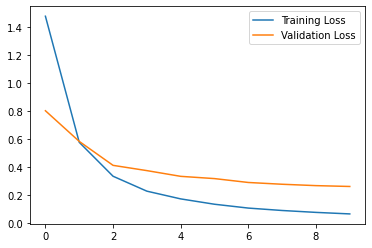

In [22]:
plt.plot(range(len(history.history['loss'])), history.history['loss'], label = 'Training Loss')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], label = 'Validation Loss')
plt.legend()

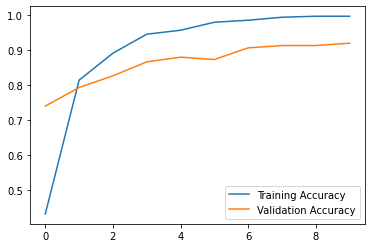

In [23]:
plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'], label = 'Training Accuracy')
plt.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()

##### Testing a Dropout Layer

The results of the basic model above seem too good, so I'm testing out a dropout layer with different rates to see how that changes things.

In [24]:
def ResNetModel2(input_shape):
    base = ResNet50(input_shape = input_shape, weights = 'imagenet',
                    include_top = False, pooling = 'avg')
    base.trainable = False
    
    inputs = Input(input_shape)
    x = resnet.preprocess_input(inputs)
    x = Dropout(0.2)(x)
    x = base(x)
    
    outputs = Dense(5, activation = 'softmax')(x)
    
    return Model(inputs, outputs, name = 'ResNetModel2')

In [25]:
model2 = ResNetModel2(input_shape = (224, 224, 3))
model2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [26]:
history2 = model2.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 10)

Epoch 1/10
11/11 [==============================] - 23s 2s/step - loss: 1.6820 - accuracy: 0.3343 - val_loss: 1.3113 - val_accuracy: 0.4267
Epoch 2/10
11/11 [==============================] - 21s 2s/step - loss: 0.9246 - accuracy: 0.6457 - val_loss: 1.0256 - val_accuracy: 0.6200
Epoch 3/10
11/11 [==============================] - 21s 2s/step - loss: 0.5533 - accuracy: 0.8029 - val_loss: 0.7805 - val_accuracy: 0.7133
Epoch 4/10
11/11 [==============================] - 21s 2s/step - loss: 0.4157 - accuracy: 0.8571 - val_loss: 0.8054 - val_accuracy: 0.6733
Epoch 5/10
11/11 [==============================] - 21s 2s/step - loss: 0.3153 - accuracy: 0.9029 - val_loss: 0.6311 - val_accuracy: 0.7800
Epoch 6/10
11/11 [==============================] - 21s 2s/step - loss: 0.2723 - accuracy: 0.9171 - val_loss: 0.6463 - val_accuracy: 0.7533
Epoch 7/10
11/11 [==============================] - 21s 2s/step - loss: 0.2207 - accuracy: 0.9543 - val_loss: 0.6282 - val_accuracy: 0.7467
Epoch 8/10
11/11 [==

Big dropoff in validation accuracy with a dropout rate of 0.2.

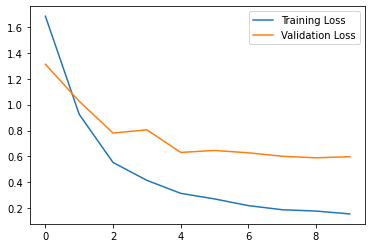

In [27]:
plt.plot(range(len(history2.history['loss'])), history2.history['loss'], label = 'Training Loss')
plt.plot(range(len(history2.history['val_loss'])), history2.history['val_loss'], label = 'Validation Loss')
plt.legend()

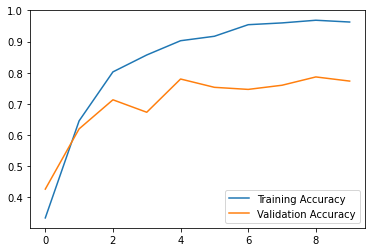

In [28]:
plt.plot(range(len(history2.history['accuracy'])), history2.history['accuracy'], label = 'Training Accuracy')
plt.plot(range(len(history2.history['val_accuracy'])), history2.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()

In [29]:
def ResNetModel3(input_shape):
    base = ResNet50(input_shape = input_shape, weights = 'imagenet',
                    include_top = False, pooling = 'avg')
    base.trainable = False
    
    inputs = Input(input_shape)
    x = resnet.preprocess_input(inputs)
    x = Dropout(0.3)(x)
    x = base(x)
    
    outputs = Dense(5, activation = 'softmax')(x)
    
    return Model(inputs, outputs, name = 'ResNetModel3')

In [30]:
model3 = ResNetModel3(input_shape = (224, 224, 3))
model3.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [32]:
history3 = model3.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 10)

Epoch 1/10
11/11 [==============================] - 18s 2s/step - loss: 0.1593 - accuracy: 0.9600 - val_loss: 0.8032 - val_accuracy: 0.6933
Epoch 2/10
11/11 [==============================] - 22s 2s/step - loss: 0.1456 - accuracy: 0.9857 - val_loss: 0.7884 - val_accuracy: 0.6800
Epoch 3/10
11/11 [==============================] - 23s 2s/step - loss: 0.1345 - accuracy: 0.9743 - val_loss: 0.8166 - val_accuracy: 0.6733
Epoch 4/10
11/11 [==============================] - 23s 2s/step - loss: 0.1280 - accuracy: 0.9829 - val_loss: 0.7415 - val_accuracy: 0.6933
Epoch 5/10
11/11 [==============================] - 21s 2s/step - loss: 0.0986 - accuracy: 0.9914 - val_loss: 0.7959 - val_accuracy: 0.6800
Epoch 6/10
11/11 [==============================] - 21s 2s/step - loss: 0.1060 - accuracy: 0.9914 - val_loss: 0.7456 - val_accuracy: 0.6933
Epoch 7/10
11/11 [==============================] - 21s 2s/step - loss: 0.0945 - accuracy: 0.9857 - val_loss: 0.8031 - val_accuracy: 0.6733
Epoch 8/10
11/11 [==

Similar performance at tenth epoch to dropout rate of 0.2, but stronger starting accuracy for both training and validation.

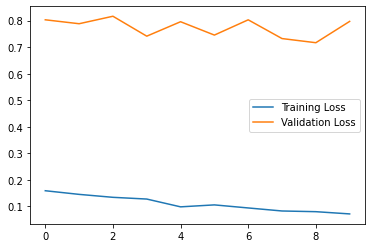

In [33]:
plt.plot(range(len(history3.history['loss'])), history3.history['loss'], label = 'Training Loss')
plt.plot(range(len(history3.history['val_loss'])), history3.history['val_loss'], label = 'Validation Loss')
plt.legend()

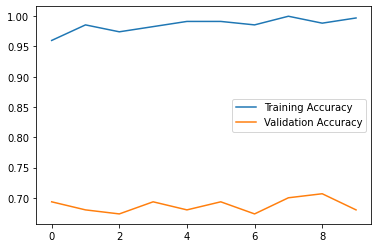

In [34]:
plt.plot(range(len(history3.history['accuracy'])), history3.history['accuracy'], label = 'Training Accuracy')
plt.plot(range(len(history3.history['val_accuracy'])), history3.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()

Using AUC as the metric below for the purposes of plotting the ROC Curve for this model in the comparison notebooks.

In [35]:
from tensorflow.keras.metrics import AUC

In [36]:
def get_model():
    model = ResNetModel3(input_shape = (224, 224, 3))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = [AUC(multi_label = True, num_labels = 5)])
    return model

model = get_model()

model.fit(x_test, y_test, epochs = 10)

model.save('my_model.keras')

Epoch 1/10
5/5 [==============================] - 7s 1s/step - loss: 1.5977 - auc: 0.6522
Epoch 2/10
5/5 [==============================] - 5s 1s/step - loss: 0.9320 - auc: 0.8865
Epoch 3/10
5/5 [==============================] - 5s 1s/step - loss: 0.6573 - auc: 0.9496
Epoch 4/10
5/5 [==============================] - 7s 1s/step - loss: 0.5109 - auc: 0.9711
Epoch 5/10
5/5 [==============================] - 6s 1s/step - loss: 0.3904 - auc: 0.9847
Epoch 6/10
5/5 [==============================] - 7s 1s/step - loss: 0.3290 - auc: 0.9904
Epoch 7/10
5/5 [==============================] - 6s 1s/step - loss: 0.2985 - auc: 0.9929
Epoch 8/10
5/5 [==============================] - 6s 1s/step - loss: 0.2461 - auc: 0.9954
Epoch 9/10
5/5 [==============================] - 6s 1s/step - loss: 0.2177 - auc: 0.9972
Epoch 10/10
5/5 [==============================] - 6s 1s/step - loss: 0.1742 - auc: 0.9987
